# Explore Binary GLM-HMM One State One Animal

**Goal:** replicate previously found results of GLM fits to PWM data with SSM package 


**Sub Goals**:

1. Single Animal Subset of Sessions
2. Single Animal All Sessions
3. Two Animal All Sessions
4. All Animals All Sessions
5. DMG -> SSM design matrix formating
6. Visuals for post fitting analysis (weights, comparison across animals)

This notebook will focus on fitting a single animal and the code necessary to do so.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ssm
from ssm.util import find_permutation

from multiglm.data.dataset_loader import *
from multiglm.features.design_matrix_generator import *
from multiglm.features.design_matrix_generator_PWM import *
from multiglm.visualizations.ssm_visualizer import *

%load_ext autoreload
%autoreload 2

sns.set_context('talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single Animal Session Subset

## Load In

In [2]:
animal_id = ["W075"]

df = DatasetLoader(
    animal_ids=["W051"], data_type="new_trained", relative_data_path="../../../data/"
).load_data()

Loading data for animal ids:  ['W051']


### Truncate


In [3]:
# Take a subset of the data
n_sessions = 20
session_min = df["session"].min()
session_stop = session_min + n_sessions

trunc_df = df.query("session >= @session_min and session < @session_stop")

## Design Matrix

In [4]:
dmg_config = {
    "bias": lambda df: (add_bias_column(df)),
    "s_a": lambda df: (standardize(df.s_a)),
    "s_b": lambda df: (standardize(df.s_b)),
    "session": lambda df: (copy(df.session)),
    "labels": binary_choice_labels(),
}

dmg = DesignMatrixGeneratorPWM(trunc_df, dmg_config, verbose=True)
X, y = dmg.create()

DMG: Creating data matrix with columns: dict_keys(['bias', 's_a', 's_b', 'session'])
DMG: Creating labels with column: choice.
DMG: Dropping 624 nan rows from data and labels.
DMG: Binary encoding labels.


In [5]:
X.head(), y[0:5]

(   bias       s_a       s_b  session
 3     1 -0.781914  0.005505      326
 4     1  0.899359  0.005505      326
 6     1  0.058723 -0.826305      326
 7     1  0.899359  0.005505      326
 8     1 -1.622550 -0.826305      326,
 array([0, 1, 1, 1, 1]))

### Format DMG for SSM

A jagged list of X, and y arrays where each array corresponds to data, or labels for a session. The number of trials per session can vary.

In [39]:
Xs, ys = prepare_data_for_ssm(X, y)

Xs[0].shape, ys[0].shape

((317, 3), (317, 1))

## Single State GLM-HMM

### Initialize

In [40]:
num_states = 1
obs_dim = 1
num_categories = 2  # left/right
input_dim = 3  # bias, s_a, s_b

In [66]:
glm_hmm = ssm.HMM(
    num_states,
    obs_dim,
    input_dim,
    observations="input_driven_obs",
    observation_kwargs=dict(C=num_categories),
    transitions="standard",
)

initial_weights = glm_hmm.observations.params.copy()

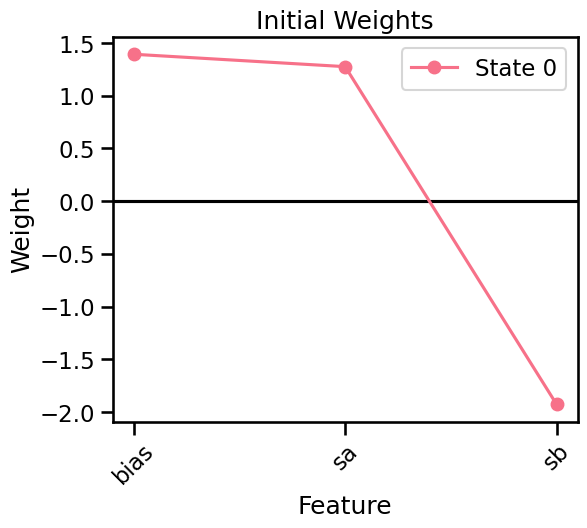

In [67]:
plot_bernoulli_weights_by_state(
    initial_weights,
    feature_names=["bias", "sa", "sb"],
    title="Initial Weights",
)

### Fit 

In [79]:
N_iters = 200  # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = glm_hmm.fit(
    ys,  # ys
    inputs=Xs,
    method="em",
    num_iters=N_iters,
    tolerance=10**-4,
)

Converged to LP: -2081.6:   0%|          | 1/200 [00:00<00:10, 19.11it/s]


### Visualize


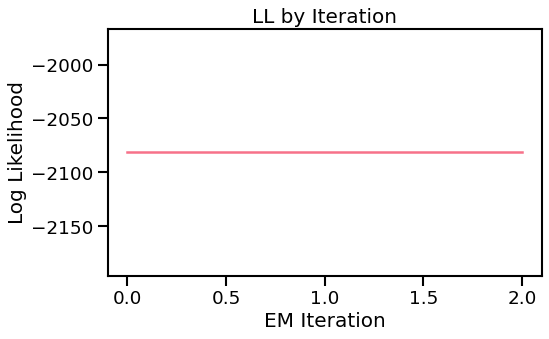

In [80]:
plot_log_likelihood_over_iters(fit_ll)

Lets look at the weights- the dashed line indicates where the weights are initialized to start. I want to indicate this since we only need 1 EM iteration to reach tolerance and break early. Indeed, it does appear the model is easily finding the GLM weights.

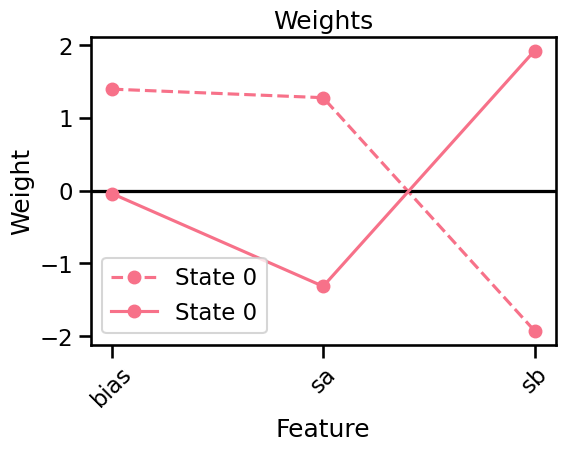

In [83]:
recovered_weights = glm_hmm.observations.params
fig, ax = plt.subplots(figsize=(6, 4))
plot_bernoulli_weights_by_state(
    initial_weights,
    feature_names=["bias", "sa", "sb"],
    linestyle="--",
    ax=ax,
)
plot_bernoulli_weights_by_state(
    recovered_weights,
    feature_names=["bias", "sa", "sb"],
    title="Weights",
    ax=ax,
)

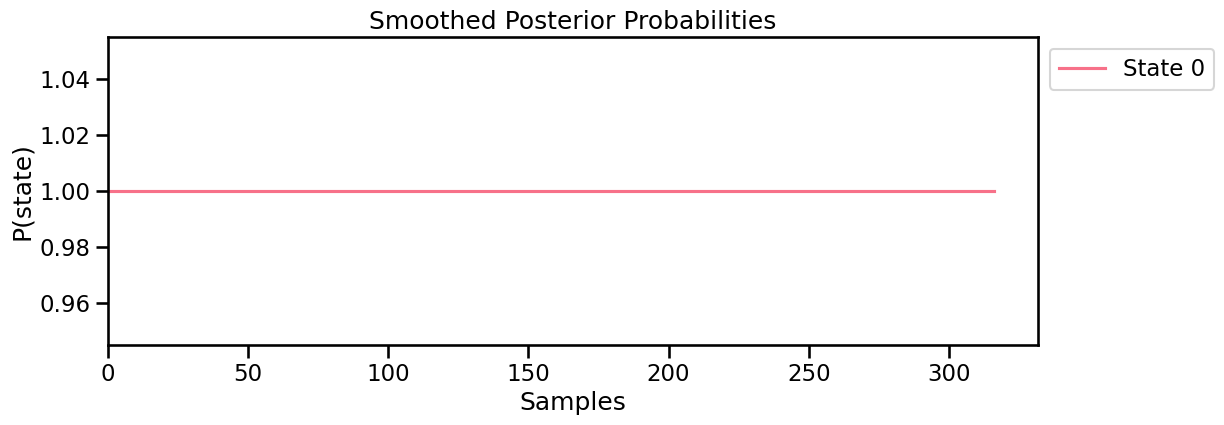

In [84]:
posterior_state_probs = get_posterior_state_probs(glm_hmm, ys, inputs=Xs)
session_to_plot = 0
plot_state_posterior(posterior_state_probs[session_to_plot])

### Interpretation of Results

Overall things look good. The weights appear to follow a pattern as expect. However the sign (+/-) of the weights is flipped from previous analyses I was doing. Typically, Sa is large and positive, while sb is large and negative. Now, Sa is negative and Sb is positive. I want to confirm that is indeed the case for fitting all sessions and other animals. 

This may be due to the underlying SSM algorithm, such that the weight vector represents L-R (where it used to be R-L in my code). To change this, I would need to re-map L:1 and R:0 I believe. 

Fitting with a single state requires only 1 EM iteration to fit the weights. The transition matrix is 1 x 1 and represents 1.00 (not plotted) and the smoothed posteriors are flat at 1 for state 0 as expected. There doesn't appear to be any need for a prior in this regime.

# Single Animal All Sessions
## Design Matrix 

In [88]:
dmg = DesignMatrixGeneratorPWM(df, dmg_config, verbose=True)
X, y = dmg.create()
Xs, ys = prepare_data_for_ssm(X, y)

DMG: Creating data matrix with columns: dict_keys(['bias', 's_a', 's_b', 'session'])
DMG: Creating labels with column: choice.
DMG: Dropping 13570 nan rows from data and labels.
DMG: Binary encoding labels.
SSM Preprocessing: 273 sessions found.


## Fit GLM-HMM
### Initialize

In [90]:
glm_hmm = ssm.HMM(
    num_states,
    obs_dim,
    input_dim,
    observations="input_driven_obs",
    observation_kwargs=dict(C=num_categories),
    transitions="standard",
)

initial_weights = glm_hmm.observations.params.copy()

### Fit

In [92]:
N_iters = 200  # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = glm_hmm.fit(
    ys,  # ys
    inputs=Xs,
    method="em",
    num_iters=N_iters,
    tolerance=10**-4,
)

Converged to LP: -41122.3:   0%|          | 1/200 [00:00<01:13,  2.70it/s]


### Visualize

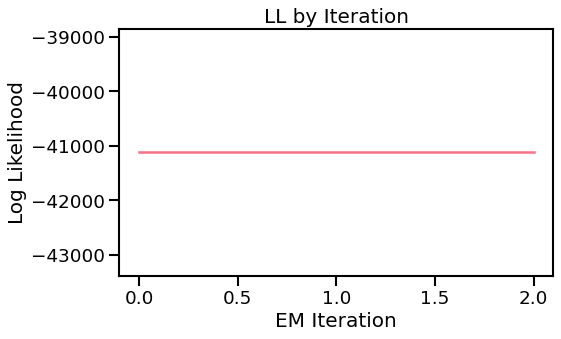

In [93]:
plot_log_likelihood_over_iters(fit_ll)

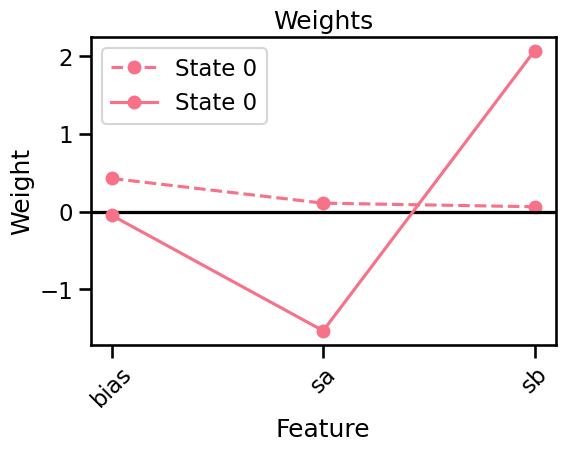

In [94]:
recovered_weights = glm_hmm.observations.params
fig, ax = plt.subplots(figsize=(6, 4))
plot_bernoulli_weights_by_state(
    initial_weights,
    feature_names=["bias", "sa", "sb"],
    linestyle="--",
    ax=ax,
)
plot_bernoulli_weights_by_state(
    recovered_weights,
    feature_names=["bias", "sa", "sb"],
    title="Weights",
    ax=ax,
)

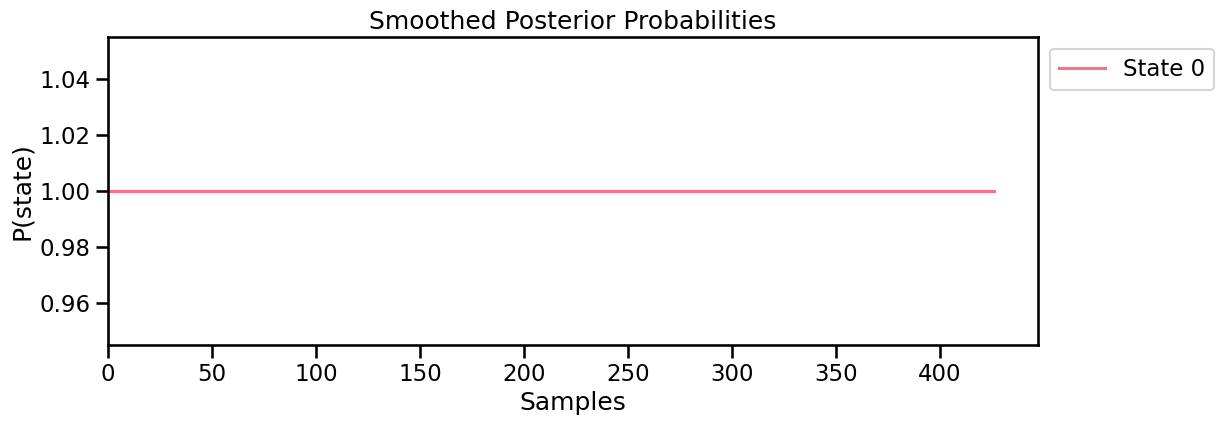

In [97]:
posterior_state_probs = get_posterior_state_probs(glm_hmm, ys, inputs=Xs)
session_to_plot = 250
plot_state_posterior(posterior_state_probs[session_to_plot])

### Interpretation of Results

Similar to the 20 trial subset, these results look similar to results previously found with a simple glm (i.e. 1 state glm-hmm). 

The weights still are flipped. 

To check on this:

[ ] see mapping of L/R wrt to weights in Zoe's paper
[ ] try with 0 and 1 flipped for L : 1 and R : 0 and see what happens


## L/R Weights

In [Zoe's paper](https://www.biorxiv.org/content/10.1101/2020.10.19.346353v4.full.pdf) it appears that left is negative and right is positive and psychometrics are set up such that it is wrt P(R). Here is figure 2. 

"the (signed) stimulus contrast, where positive values indicate a right-side grating and negative values indicate a left-side grating"

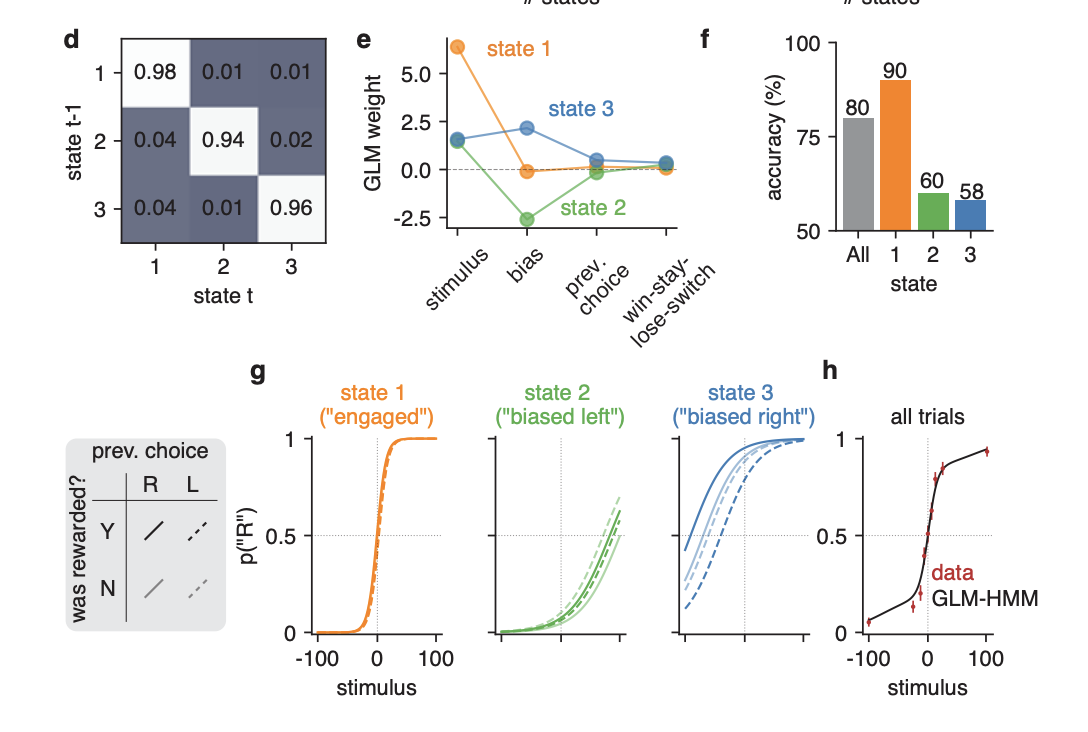

Interpreting the weights recovered here, this means that a larger sa indicates go left and a larger sb indicates go right.

However, when looking at the rule of the task this doesn't add up. Bigger sa means go right. The weights recovered look similar to those athena found (h), but her model was predicted P(L)

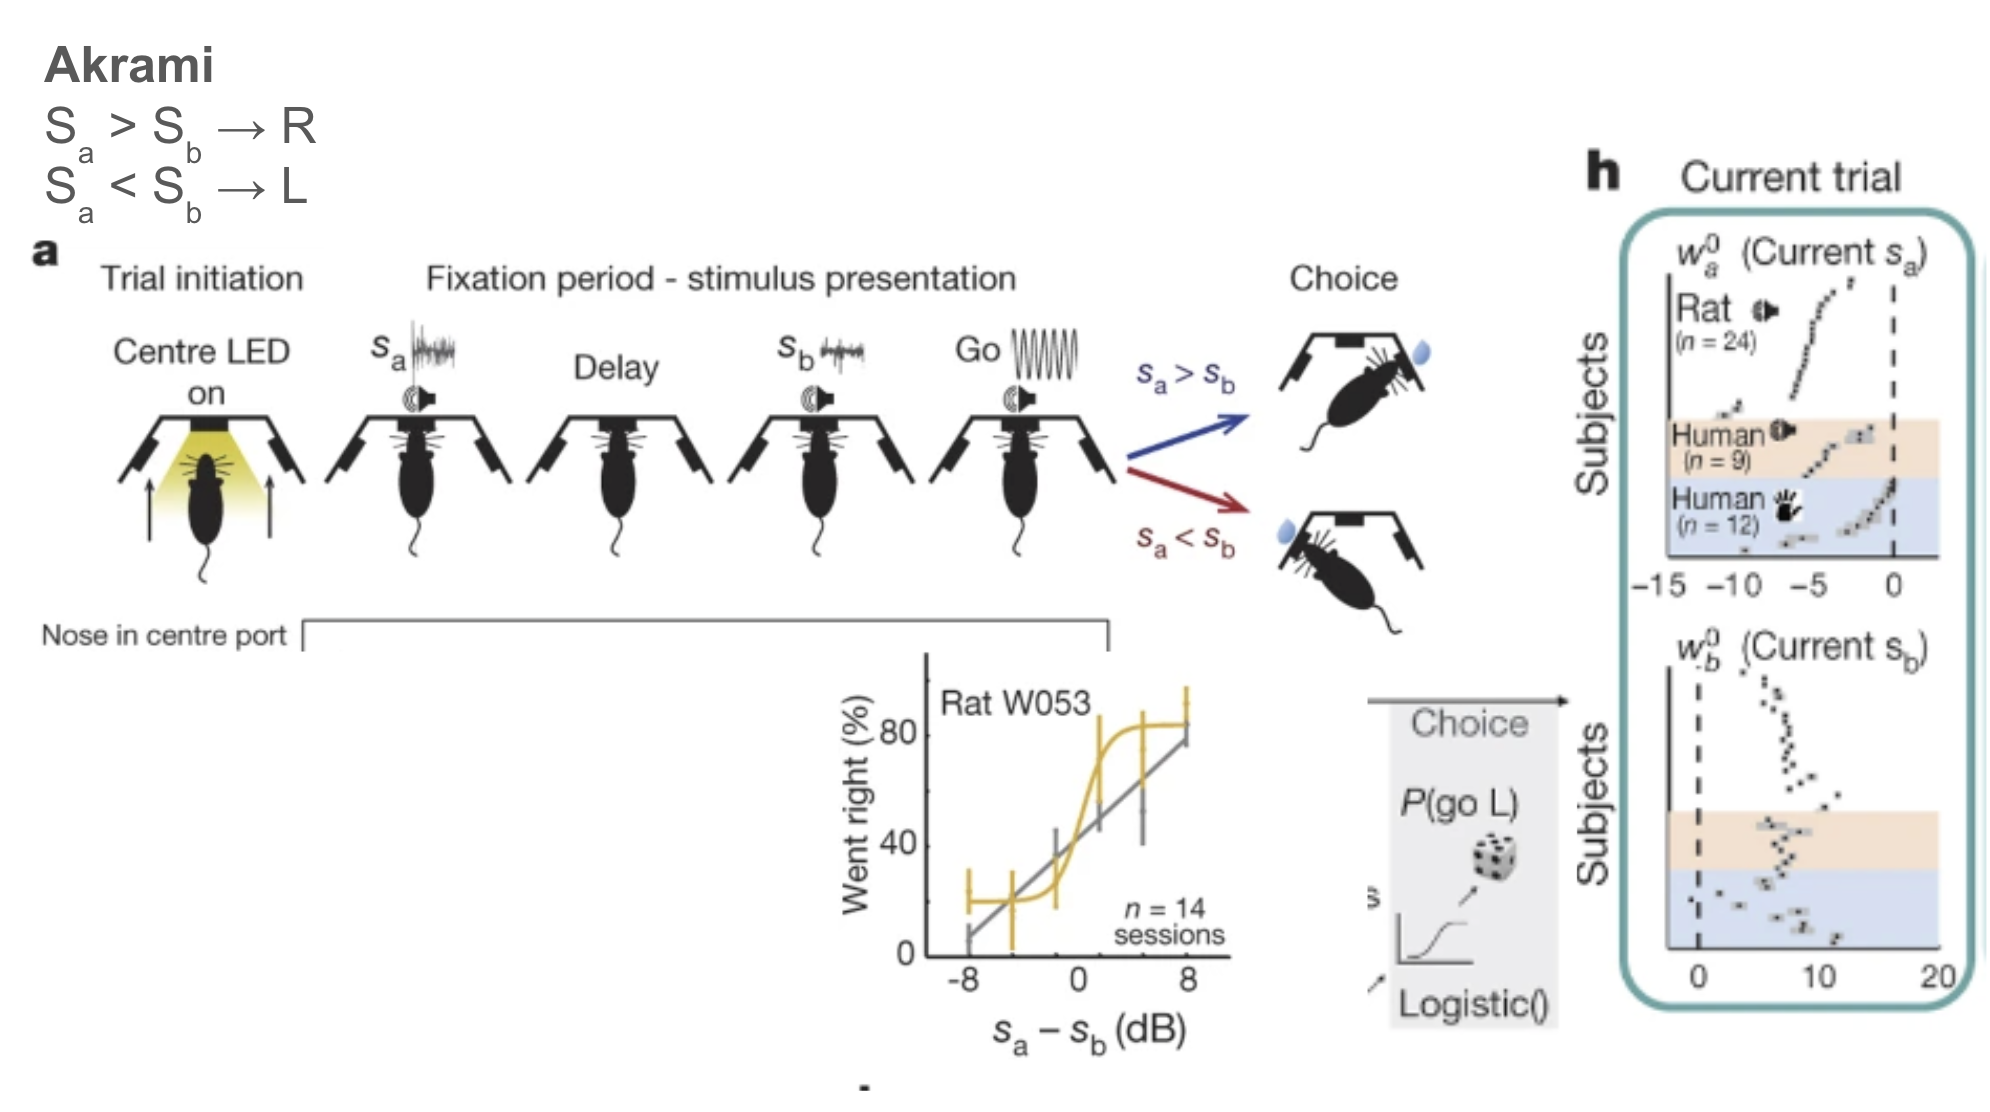

This will require just a bit more digging into. Specifically I want to do the following:

* look at single row of design matrix and ensure +/- sa, sb make sense wrt to y values
* see what happens when y values flip
* step through code idk? 